In [13]:
import pandas as pd
import numpy as np
import yfinance as yf

In [14]:
tickers = ['AAPL']
data = yf.download(tickers, start = '2024-01-01', end = '2025-4-17')
data = data['Close']
df = pd.DataFrame(data)
df.tail()

[*********************100%***********************]  1 of 1 completed


Ticker,AAPL
Date,
2025-04-10,190.419998
2025-04-11,198.149994
2025-04-14,202.520004
2025-04-15,202.139999
2025-04-16,194.270004


In [15]:
df['Log Returns'] = np.log(df['AAPL']/df['AAPL'].shift(1))
df = df.dropna()
df.tail()

Ticker,AAPL,Log Returns
Date,,
2025-04-10,190.419998,-0.043319
2025-04-11,198.149994,0.039792
2025-04-14,202.520004,0.021814
2025-04-15,202.139999,-0.001878
2025-04-16,194.270004,-0.039712


Calculating the Parameters

In [16]:
S_0 = round(df['AAPL'].iloc[-1],2)
print(f'S0 Value: {S_0}')
sigma_annual = (df['Log Returns'].std())*np.sqrt(252)
print(f'Sigma Annual: {sigma_annual}')

S0 Value: 194.27
Sigma Annual: 0.29987397545108635


In [17]:
t_bills = yf.download("^IRX", start="2024-01-01", end="2025-04-17")
r = t_bills['Close'].iloc[-1]/100
print(f'Risk-Free Rate: {r}')

[*********************100%***********************]  1 of 1 completed

Risk-Free Rate: Ticker
^IRX    0.04208
Name: 2025-04-16 00:00:00, dtype: float64


In [18]:
print(f'S_0: {S_0}\nSigma Annual: {sigma_annual}\nRisk Free Rate: {r} ')

S_0: 194.27
Sigma Annual: 0.29987397545108635
Risk Free Rate: Ticker
^IRX    0.04208
Name: 2025-04-16 00:00:00, dtype: float64 


In [19]:
def binomial_american_option(S0, K, T, r, sigma, N, option_type="put", american=True):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    q = (np.exp(r * dt) - d) / (u - d)

    # Initialize asset prices at maturity
    ST = np.array([S0 * (u ** j) * (d ** (N - j)) for j in range(N + 1)])
    
    # Option values at maturity
    if option_type == "call":
        V = np.maximum(ST - K, 0)
    else:
        V = np.maximum(K - ST, 0)

    # Step backward through tree
    for t in range(N - 1, -1, -1):
        for i in range(t + 1):
            ST_i = S0 * (u ** i) * (d ** (t - i))
            exercise = max(K - ST_i, 0) if option_type == "put" else max(ST_i - K, 0)
            hold = np.exp(-r * dt) * (q * V[i + 1] + (1 - q) * V[i])
            V[i] = max(exercise, hold) if american else hold

    return V[0]

In [20]:
S_0 = float(df['AAPL'].iloc[-1])
sigma_annual = float((df['Log Returns'].std()) * np.sqrt(252))
r = float(t_bills['Close'].iloc[-1]) / 100

K = 195       # strike price (adjust if needed)
T = 1 / 12    # 1 month to expiration
N = 100       # time steps
option_type = "put"

price = binomial_american_option(S_0, K, T, r, sigma_annual, N, option_type=option_type)

print(f"""S_0: {S_0}
Sigma Annual: {sigma_annual}
Risk Free Rate: {r}

Binomial American {option_type.title()} Option Price: {price:.4f}
""")


S_0: 194.27000427246094
Sigma Annual: 0.29987397545108635
Risk Free Rate: 0.04208000183105469

Binomial American Put Option Price: 6.7887



/var/folders/9p/bvy9kzls70qg_lj9g9xhcxv80000gn/T/ipykernel_33928/3177168699.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  r = float(t_bills['Close'].iloc[-1]) / 100


In [21]:
# Convergence test - change N and observe price stability
N_values = [25, 50, 100, 150, 200, 250]
convergence_results = []

for N_test in N_values:
    p = binomial_american_option(S_0, K, T, r, sigma_annual, N_test, option_type="put")
    convergence_results.append((N_test, p))

# Print results
print("Convergence Test (Varying Steps N):")
for n, price in convergence_results:
    print(f"Steps: {n}, Price: {price:.4f}")


Convergence Test (Varying Steps N):
Steps: 25, Price: 6.8439
Steps: 50, Price: 6.7875
Steps: 100, Price: 6.7887
Steps: 150, Price: 6.7878
Steps: 200, Price: 6.7869
Steps: 250, Price: 6.7861


In [22]:
# Sensitivity test - change sigma and observe impact on price
sigma_values = [0.20, 0.25, 0.30, 0.35]
sensitivity_results = []

for sigma_test in sigma_values:
    p = binomial_american_option(S_0, K, T, r, sigma_test, N, option_type="put")
    sensitivity_results.append((sigma_test, p))

# Print results
print("\nSensitivity Test (Varying Volatility σ):")
for sigma, price in sensitivity_results:
    print(f"Volatility: {sigma:.2f}, Price: {price:.4f}")



Sensitivity Test (Varying Volatility σ):
Volatility: 0.20, Price: 4.5621
Volatility: 0.25, Price: 5.6768
Volatility: 0.30, Price: 6.7915
Volatility: 0.35, Price: 7.9059


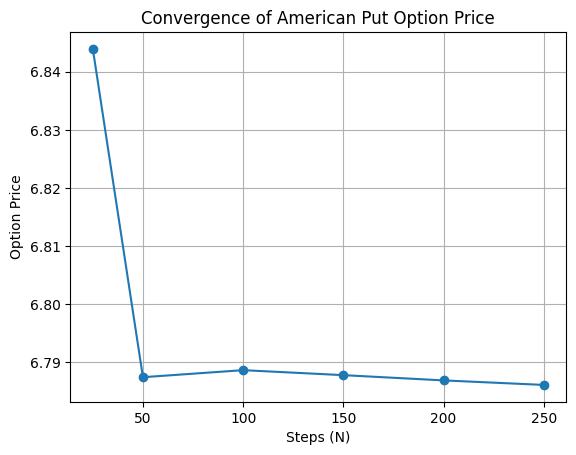

In [23]:
import matplotlib.pyplot as plt

n_vals, p_vals = zip(*convergence_results)
plt.plot(n_vals, p_vals, marker='o')
plt.xlabel("Steps (N)")
plt.ylabel("Option Price")
plt.title("Convergence of American Put Option Price")
plt.grid(True)
plt.show()


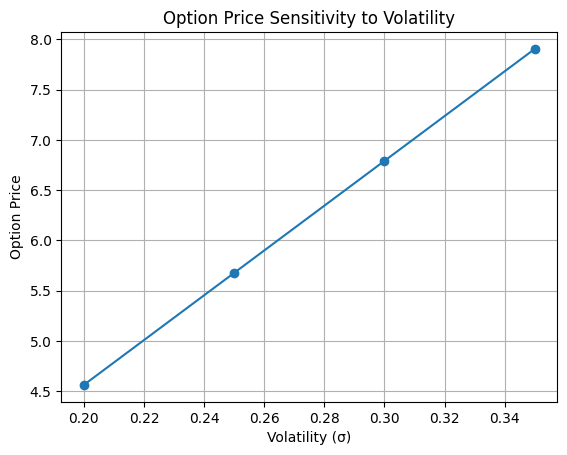

In [24]:
s_vals, p_vals = zip(*sensitivity_results)
plt.plot(s_vals, p_vals, marker='o')
plt.xlabel("Volatility (σ)")
plt.ylabel("Option Price")
plt.title("Option Price Sensitivity to Volatility")
plt.grid(True)
plt.show()
